In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from parser.inflation import download_inflation, get_inflation_df
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df
from parser.dollar import get_dollar_df
from parser.broad_money_supply import get_broad_money_supply

import dateparser
import matplotlib.dates as mdates

Получим данные по объему кредитов

In [3]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024))
df

,msp_loans,month_n,year,Отчетный период
0,422396.0,2,2019,Февраль 2019 г.
1,30596.0,2,2019,Февраль 2019 г.
2,452992.0,2,2019,Февраль 2019 г.
3,482114.0,3,2019,Март 2019 г.
4,37931.0,3,2019,Март 2019 г.
...,...,...,...,...
187,2096.0,4,2024,Апрель 2024 г.
188,1524903.0,4,2024,Апрель 2024 г.
189,1586883.0,5,2024,Май 2024 г.
190,4790.0,5,2024,Май 2024 г.


Выгружаем данные по инфляции и ключевой ставке

In [4]:
start_date = datetime.datetime.strptime("01.02.2019", "%d.%m.%Y")
end_date = datetime.datetime.strptime("01.06.2024", "%d.%m.%Y")
download_inflation(start_date, end_date)
df_inflation = transform_df_to_format(get_inflation_df(start_date, end_date))
df_inflation

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,"Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year,Отчетный период
0,7.75,5.20,2,2019,Февраль 2019 г.
28,7.75,5.30,3,2019,Март 2019 г.
59,7.75,5.20,4,2019,Апрель 2019 г.
89,7.75,5.10,5,2019,Май 2019 г.
120,7.50,4.70,6,2019,Июнь 2019 г.
...,...,...,...,...,...
1795,16.00,7.44,1,2024,Январь 2024 г.
1826,16.00,7.69,2,2024,Февраль 2024 г.
1855,16.00,7.72,3,2024,Март 2024 г.
1886,16.00,7.84,4,2024,Апрель 2024 г.


Выгружаем данные о курсе доллара

In [5]:
df_dollar = transform_df_to_format(get_dollar_df(start_date, end_date))
df_dollar

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,curs,month_n,year,Отчетный период
0,90.1915,6,2024,Июнь 2024 г.
1,89.7869,5,2024,Май 2024 г.
2,89.2589,5,2024,Май 2024 г.
3,88.4375,5,2024,Май 2024 г.
4,88.6852,5,2024,Май 2024 г.
...,...,...,...,...
1308,65.6686,2,2019,Февраль 2019 г.
1309,65.5691,2,2019,Февраль 2019 г.
1310,65.5859,2,2019,Февраль 2019 г.
1311,65.6601,2,2019,Февраль 2019 г.


Выгружаем данные о широкой денежной массе 

In [37]:
broad_money_supply = transform_df_to_format(get_broad_money_supply(2015, 2024))
broad_money_supply

,broad_money,month_n,year,Отчетный период
0,31033.7,2,2015,Февраль 2015 г.
1,506.5,3,2015,Март 2015 г.
2,31028.8,4,2015,Апрель 2015 г.
3,546.6,5,2015,Май 2015 г.
4,31820.4,6,2015,Июнь 2015 г.
...,...,...,...,...
107,4.2,1,2024,Январь 2024 г.
108,97816.7,2,2024,Февраль 2024 г.
109,99422.0,3,2024,Март 2024 г.
110,99595.8,4,2024,Апрель 2024 г.


Соединяем датафреймы для получения итогового

In [37]:
df_total = pd.merge(df, df_inflation, on='Отчетный период', how='inner')
df_total.head()

,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year
0,Январь 2022 г.,800529,8.5,8.73,1,2022
1,Февраль 2022 г.,964639,20.0,9.15,2,2022
2,Март 2022 г.,816031,20.0,16.69,3,2022
3,Апрель 2022 г.,808912,17.0,17.83,4,2022
4,Май 2022 г.,676283,11.0,17.10,5,2022


In [38]:
df_total_for_corr = df_total.drop('Отчетный период', axis = 1) # убираем отчетный период, так как данный тип данных мешает рассчету корреляции
df_total_for_corr.corr()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year
"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",1.000000,0.114866,-0.619060,0.652899,0.439009
"Ключевая ставка, % годовых",0.114866,1.000000,0.142106,-0.093470,0.065087
"Инфляция, % г/г",-0.619060,0.142106,1.000000,-0.002229,-0.734708
month_n,0.652899,-0.093470,-0.002229,1.000000,-0.156206
year,0.439009,0.065087,-0.734708,-0.156206,1.000000


Оставляем параметры, которые показали хорошую корреляцию с объемом кредитов

In [39]:
df_total = df_total[['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', 'Инфляция, % г/г', 'month_n']]
df_total.head()

,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Инфляция, % г/г",month_n
0,Январь 2022 г.,800529,8.73,1
1,Февраль 2022 г.,964639,9.15,2
2,Март 2022 г.,816031,16.69,3
3,Апрель 2022 г.,808912,17.83,4
4,Май 2022 г.,676283,17.10,5


Подготовка данных и обучение модели

In [45]:
# разделение данных на тестовые и тренировочные
split_index = 20
trn = df_total[df_total.index<split_index]
test = df_total[df_total.index>=split_index]

trn = trn.copy()
trn['Отчетный период'] = trn['Отчетный период'].apply(lambda x: dateparser.parse(x, languages=['ru'])).dt.strftime('%Y-%m')
test = test.copy()
test['Отчетный период'] = test['Отчетный период'].apply(lambda x: dateparser.parse(x, languages=['ru'])).dt.strftime('%Y-%m')

# тренировочные данные
Xtrn = trn.drop(['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'], axis = 1)
Ytrn = trn['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']

# тренировочные данные
Xtest = test.drop(['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'], axis = 1)
Ytest = test['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']

In [46]:
# Создание и обучение модели
regressor = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1231474.8336257  1219988.3343901  1154351.14661386 1164035.44810847
  935381.92163782]


In [47]:
Ytest # можно сравнить с тем, что получилось выше

20    1576041
21    1734270
22    1379337
23    1854476
24     935130
Name: Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего, dtype: object

Рассчет средней абсолютной процентная ошибки (MAPE) - средняя разница между прогнозируемым значением и фактическим значением

In [52]:
def mape( actual , pred ): 
 actual, pred = np.array(actual), np.array(pred)
 return np.mean(np.abs((actual - pred) / actual))* 100

mape(Ytest.values, predictions)

21.017193799372716

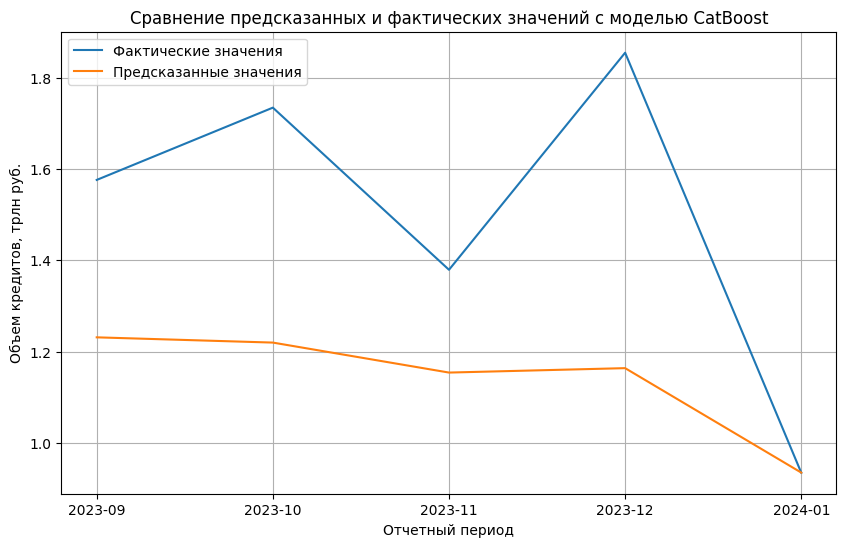

In [53]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test['Отчетный период'], Ytest.values/ 1e6, label='Фактические значения')
plt.plot(test['Отчетный период'], predictions/ 1e6, label='Предсказанные значения')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью CatBoost')
plt.legend()
plt.grid(True)
plt.show()

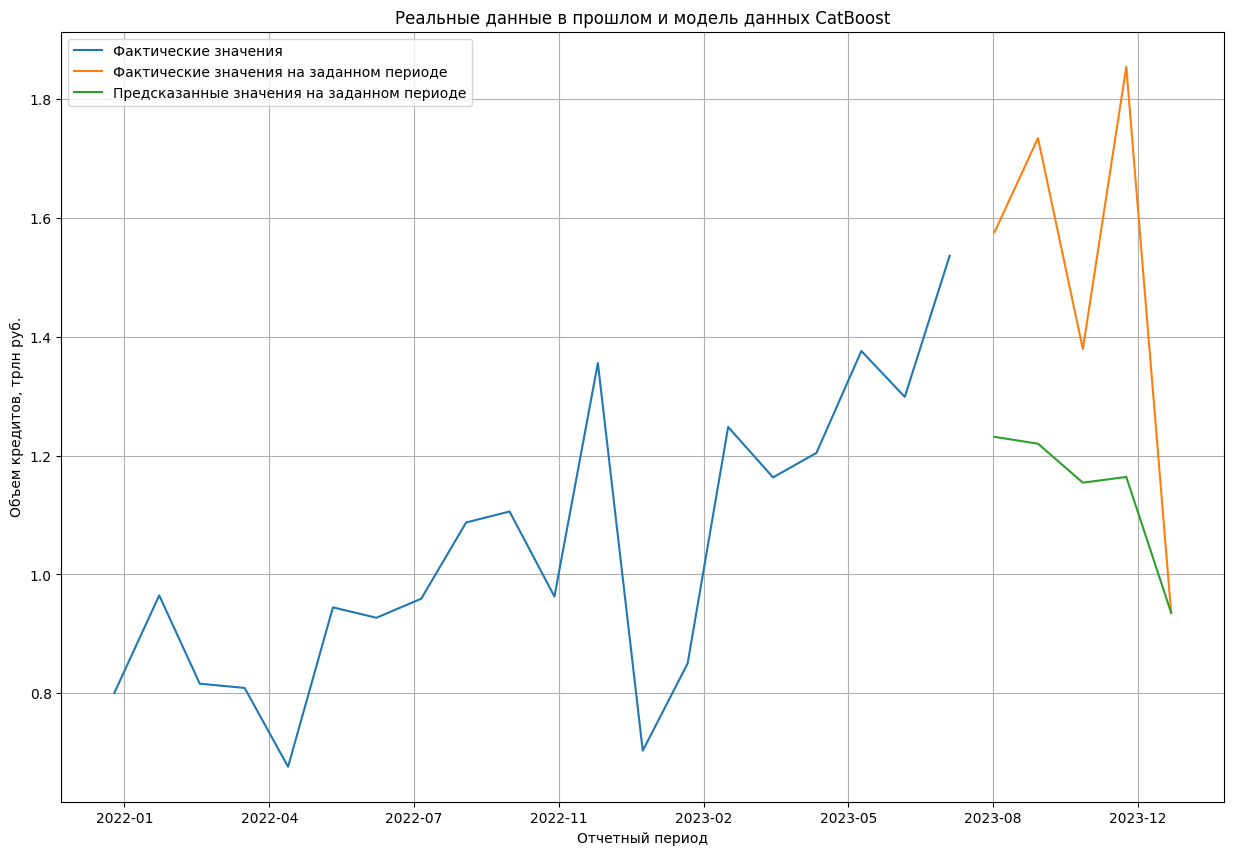

In [55]:
# Построение графика
plt.figure(figsize=(15, 10))
plt.plot(mdates.date2num(trn['Отчетный период']), Ytrn.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['Отчетный период']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['Отчетный период']), predictions/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

Выполним предсказание до конца 2025 года